# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy
import joblib
from scipy.stats import beta

# Data input & initial organization functions

## import_price_data
*This function imports the raw price data and organizes it for use.*

In [2]:
def import_price_data(main,filename):
    # Set columns from WRDS price dataset to import
    col_list = ['COMNAM','TSYMBOL','date','PRC','VOL']
    # Import price dataset
    price_data = pd.read_csv(main+filename,usecols=col_list)
    # Convert date to useable format
    price_data['date'] = pd.to_datetime(price_data['date'],format='%Y%m%d')
    # Rename columns
    price_data = price_data.rename(columns={'COMNAM':'CompanyName','TSYMBOL':'Ticker','date':'Date','PRC':'Price','VOL':'Volume'})
    # Load SimFin dataset for 2021 prices
    finsim_price_dataloc = '/Users/DanBickelhaupt/Desktop/Coding/AI_Investor_Book/SimFin_Free_Data/us-shareprices-daily.csv'
    recent_prices = pd.read_csv(finsim_price_dataloc,delimiter=';',usecols=['Ticker','Date','Close','Volume'])
    recent_prices['Date'] = pd.to_datetime(recent_prices['Date'])
    recent_prices = recent_prices.rename(columns = {'Close':'Price'})
    recent_prices = recent_prices[recent_prices['Date'].dt.year == 2021]
    # Merge datasets
    price_data = pd.concat([price_data,recent_prices],axis=0)
    # Remove bad rows
    bool_list = ~(price_data['Price'] < 0 | price_data['Ticker'].isnull() | price_data['Date'].isnull() | price_data['Price'].isnull() | price_data['Volume'].isnull())
    price_data = price_data[bool_list]
    bool_list = ~(price_data['Ticker'].isna() | price_data['Date'].isna() | price_data['Price'].isna() | price_data['Volume'].isna())
    price_data = price_data[bool_list]
    # Return dataframe
    price_data = price_data.reset_index(drop=True)
    return price_data

## import_fund_data
*This function imports the fundamental financial statement dataset, then grabs & organizes the relevant data.*

In [3]:
def import_fund_data(main,filename):
    # Set columns from Compustat price dataset to import
    col_list = ['conm','tic','fyear','datadate','ni','xint','txt','csho','dltt','dlc','che','oiadp','act','lct','ppent','ceq','sale','at','lt','cogs','seq','oancf','capx','re']
    # Import fundamental dataset
    funda_data = pd.read_csv(main+filename,usecols=col_list)
    # Convert date to useable format
    funda_data['datadate'] = pd.to_datetime(funda_data['datadate'],format='%Y%m%d')
    # Rename columns
    funda_data = funda_data.rename(columns={'conm':'CompanyName','tic':'Ticker','fyear':'Year','datadate':'StatementDate',\
                                       'ni':'NetIncome','xint':'NetInterestExpense','txt':'NetIncomeTax','csho':'CommonSharesOutstanding',\
                                       'dltt':'LongTermDebt','dlc':'ShortTermDebt','che':'Cash','oiadp':'OpIncome','act':'TotalCurrentAssets',\
                                       'lct':'TotalCurrentLiabilities','ppent':'NetPPE','ceq':'TotalEquity','sale':'Revenue',\
                                       'at':'TotalAssets','lt':'TotalLiabilities','cogs':'COGS','seq':'ShareholderEquity',\
                                       'oancf':'OpCashFlow','capx':'CapEx','re':'RetainedEarnings'})
    # Add EBIT
    funda_data['EBIT'] = funda_data['NetIncome'] - funda_data['NetInterestExpense'] - funda_data['NetIncomeTax']
    # Fix NaNs
    for key in funda_data.keys():
        funda_data.loc[funda_data[key].isnull() | funda_data[key].isna(), key] = 0
    # Return dataframe
    return funda_data

## get_price_near_date
*This function returns the price of the given ticker near the date provided (date can be modifier with "modifier" parameter).*

In [4]:
def get_price_near_date(ticker,date,modifier,p_data):
    buffer = 30 # number of days after (date+modifier) to search for a valid price datapoint
    search = p_data[(p_data['Date'].between(pd.to_datetime(date)+pd.Timedelta(days=modifier),pd.to_datetime(date)+pd.Timedelta(days=buffer+modifier))) & (p_data['Ticker']==ticker)]
    if search.empty:
        return [ticker , np.float('NaN') , np.datetime64('NaT') , np.float('NaN')]
    else:
        return [ticker , search.iloc[0]['Price'] , search.iloc[0]['Date'] , search.iloc[0]['Volume']]

## get_statement_price
*This function compiles the price data for each datapoint in the given fundamental dataset.*

In [5]:
def get_statement_price(fin_data,p_data,delay=0):
    # Pre-allocate output matrix
    y = [[None]*4 for i in range(len(fin_data))]
    # Set date column heading to interrogate
    dateColHeading = 'StatementDate'
    # Setup to search by year (which is hopefully faster)
    fin_data['StatementDate'] = pd.to_datetime(fin_data['StatementDate'])
    fyears = fin_data.Year.unique()
    # Loop thru all years in 'fin_data'
    i = 0
    for year in fyears:
        # Separate out a subset of financial statement data that's just for the current year.
        bool_list = (fin_data['StatementDate'].dt.year == year)
        sub_fin_data = fin_data[bool_list] 
        # Separate out a subset of price data that's for the current year thru 2 years from current year.
        bool_list = ((p_data['Date'].dt.year == year) | (p_data['Date'].dt.year == year+1) | (p_data['Date'].dt.year == year+2))
        sub_p_data = p_data[bool_list]
        # Index thru each finanical statment datapoint in the current year 
        for index in range(len(sub_fin_data)):
            y[i] = (get_price_near_date(sub_fin_data['Ticker'].iloc[index],sub_fin_data[dateColHeading].iloc[index],delay,sub_p_data))
            i += 1            
            if i % round(len(fin_data)/100) == 0:
                print('Statement price pull {:0.0f}% complete.'.format(i/len(fin_data)*100))
        # Append index to maintain orginal order of fin_data dataframe
        if year == fyears[0]:
            # If first iteration thru, make new index variable
            save_idx_order = sub_fin_data.index
        else:
            save_idx_order = save_idx_order.append(sub_fin_data.index)
    y = pd.DataFrame(y,index=save_idx_order,columns=['Ticker','Price','Date','Volume'])
    y = y.sort_index()
    return y

## cull_data
*This function takes in the fundamental financial dataset and price dataset and cull the datapoints with "bad" data.*

In [6]:
def cull_data(f_data,p_data):
    # Create copies of input data
    culled_f_data = f_data.copy()
    culled_p_data = p_data.copy()
    # Cull data
    bool_list = ~(culled_p_data['Price'].isna())
    culled_f_data = culled_f_data[bool_list]
    culled_p_data = culled_p_data[bool_list]
    bool_list = ~(culled_f_data['CommonSharesOutstanding'].isna())
    culled_f_data = culled_f_data[bool_list]
    culled_p_data = culled_p_data[bool_list]
    bool_list = ~(culled_f_data['CommonSharesOutstanding']== 0)
    culled_f_data = culled_f_data[bool_list]
    culled_p_data = culled_p_data[bool_list]
    bool_list = ~(culled_p_data['Date'].isna())
    culled_f_data = culled_f_data[bool_list]
    culled_p_data = culled_p_data[bool_list]
    # Reset indices
    culled_f_data = culled_f_data.reset_index(drop=True)
    culled_p_data = culled_p_data.reset_index(drop=True)
    # Return datasets
    return culled_f_data , culled_p_data

## add_MC_EV
*This function computes the market captalization (MC) and enterprise value (EV) for the provided dataset.*

In [7]:
def add_MC_EV(data,price):
    data['MarketCap'] = price['Price'] * data['CommonSharesOutstanding']
    data['MarketCapDate'] = price['Date']
    data['EV'] = data['MarketCap'] + data['LongTermDebt'] + data['ShortTermDebt'] - data['Cash']
    return data

# Data preparation functions

## compile_nplus_results
*This function lines up each datapoint for a given company with a datapoint for the same company N+ years in the future (if possible).*

In [8]:
def compile_nplus_results(data, N):
    in_idx = []
    ou_idx = []
    companies = data['Ticker'].unique()
    for i, company in enumerate(companies):
        cur_data = data.loc[data['Ticker'] == company]
        in_idx.extend(cur_data.index[0:-N])
        ou_idx.extend(cur_data.index[N:])
        if len(companies) >= 20:
            if i % round(len(companies)/20) == 0:
                print('N-plus results {:0.0f}% complete.'.format(i/len(companies)*100))
    in_data = data.loc[in_idx].reset_index(drop=True)
    ou_data = data.loc[ou_idx].reset_index(drop=True)
    return in_data, ou_data

## compute_ratio_data
*This function computes the financial ratios from the given dataset to be used as the training dataset by the downstream machine learning model.*

In [9]:
def compute_ratio_data(data):
    ratio_data = pd.DataFrame()
    ratio_data['P/E'] = data['MarketCap'] / data['NetIncome']
    ratio_data['P/B'] = data['MarketCap'] / data['TotalEquity']
    ratio_data['P/S'] = data['MarketCap'] / data['Revenue']
    ratio_data['P/OpIn'] = data['MarketCap'] / data['OpIncome']
    ratio_data['P/FCF'] = data['MarketCap'] / (data['OpCashFlow'] - data['CapEx'])
    ratio_data['FCF/OpCF'] = (data['OpCashFlow'] - data['CapEx']) / data['OpCashFlow']
    ratio_data['EV/EBIT'] = data['EV'] / data['EBIT']
    ratio_data['CurrentRatio'] = data['TotalCurrentAssets'] / data['TotalCurrentLiabilities']
    ratio_data['ROA'] = data['NetIncome'] / data['TotalAssets']
    ratio_data['ROCE'] = data['EBIT'] / (data['TotalAssets'] - data['TotalCurrentLiabilities'])
    ratio_data['ROE'] = data['NetIncome'] / data['TotalEquity']
    ratio_data['NetProfitMargin'] = data['NetIncome'] / data['Revenue']
    ratio_data['DebtRatio'] = data['TotalAssets'] / data['TotalLiabilities']
    ratio_data['CashRatio'] = data['Cash'] / data['TotalCurrentLiabilities']
    return ratio_data

## clean_dataset
*This function cleans up the "bad" datapoints after the **compute_ratio_data** operation is performed on the dataset.*

In [10]:
def clean_dataset(df_x, df_y):
    assert isinstance(df_x, pd.DataFrame), "df needs to be a pd.DataFrame"
    assert isinstance(df_y, pd.DataFrame), "df needs to be a pd.DataFrame"
    indices_to_keep = ~(df_x.isin([np.nan, np.inf, -np.inf]).any(1))
    df_x = df_x[indices_to_keep].astype(np.float64)
    df_y = df_y[indices_to_keep]
    out_idx = list(df_x.index)
    df_x.reset_index()
    df_y.reset_index()
    return df_x, df_y, out_idx

## remove_first_datapoint
*This function removes first k datapoints for each company to remove erroneous pre-IPO valuations from the dataset.*

In [11]:
def remove_first_datapoint(x_data, y_data, k):
    names = x_data['CompanyName'].unique()
    drop_idx = []
    for name in names:
        subset = x_data[x_data['CompanyName']==name]
        drop_idx += list(subset.index[0:k])
    data_ou_x = x_data.drop(drop_idx, axis=0)
    data_ou_y = y_data.drop(drop_idx, axis=0)
    data_ou_x.reset_index(drop=True)
    data_ou_y.reset_index(drop=True)
    return data_ou_x, data_ou_y

## min_max_transform
*This function linearly transforms each feature of the inputted data (in DataFrame format) between a & b (defaults to between 0 and 1).*

In [12]:
def min_max_transform(data, feature_list, a=0, b=1):
    data_trans = data.copy()    
    for feat in feature_list:
        data_trans[feat] = (data_trans[feat] - data_trans[feat].min()) / (data_trans[feat].max() - data_trans[feat].min()) * (b - a) - a
    return data_trans

# Model evaluation functions

## modelMSE
*This function computes the means-squared-error between the provided prediction and the actual values.*

In [13]:
def modelMSE(y,y_pred,verbose=0):
    import numpy as np
    N = len(y)
    mse = (1/N)*np.sum((y-y_pred)**2)
    if verbose == 1:
        print('Mean Squared Error: {:0.6f}'.format(mse))
    return mse

## shuffle_data
*This helper function shuffles the indicies of an N-length vector/array.*

In [14]:
def shuffle_data(N):
    random.seed(a=None)
    index = list(range(N))
    random.shuffle(index)
    return index

## create_folds
*This function creates the folds for k-folds cross validation for a machine learning model. It returns a list of lists, each sub-list is the indicies for each fold.*

In [15]:
def create_folds(data, n): 
    xs = shuffle_data(len(data))
    k, m = divmod(len(xs), n)
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

## create_train_test
*This function creates testing and training splits given the folds created by **create_folds** and the index of the fold you're currently on.*

In [16]:
def create_train_test(folds, index):
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

## plot_train_test_prediction
*This function plots the training and testing predictions vs actual in a compact plot format.*

In [17]:
def plot_train_test_prediction(y_pred_tr, y_act_tr, y_pred_te, y_act_te, bw, plt_title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(y_pred_tr,y_act_tr,'x')
    ax1.plot([np.min(y_act_tr),np.max(y_act_tr)],[np.min(y_act_tr),np.max(y_act_tr)],'r--')
    ax1.plot([bw, bw], [0, np.max(y_act_tr)], 'k--')
    ax1.set_title(plt_title[0])
    ax1.set(xlabel='Prediction', ylabel='Actual')
    ax2.plot(y_pred_te,y_act_te,'x')
    ax2.plot([np.min(y_act_te),np.max(y_act_te)],[np.min(y_act_te),np.max(y_act_te)],'r--')
    ax2.plot([bw, bw], [0, np.max(y_act_te)], 'k--')
    ax2.set_title(plt_title[1])
    ax2.set(xlabel='Prediction', ylabel='Actual')

## over_x
*This function returns the company name, ticker, predicted value, and actual value for datapoints predicted to be > x.*

In [18]:
def over_x(x, y_pred, y_actl, data, original_idx):
    over100_pred = y_pred[y_pred > x]
    over100_idx = list(np.where(y_pred>x)[0])
    data_idx = []
    for j in over100_idx: data_idx.append(original_idx[j])
    over100_actl = y_actl[over100_idx]
    tickers = data['Ticker'][data_idx].values
    companies = data['CompanyName'][data_idx].values
    date = data['MarketCapDate'][data_idx].values
    return [companies, tickers, date, over100_pred, over100_actl]

## load_data
*This function loads and prepares the data from the price and financial statement datasets for machine learning modeling.*

In [19]:
def load_data(N, remove_n=0, prepare_data=False, full_import=False):
    ## Import datasets
    if full_import:
        # Import datasets
        data_repo = '/Users/DanBickelhaupt/Desktop/Coding/WRDS_Datasets/'
        price_file = 'crsp_monthly_price_dataset.csv'
        raw_price_data = import_price_data(data_repo,price_file)
        funda_file = 'compustat_annual_fundamental_dataset.csv' 
        funda_data = import_fund_data(data_repo,funda_file)
        # Get price data for statement dataset
        est_statement_release_delay = 55 # estimated time between statement date & publish date
        price_data = get_statement_price(funda_data, raw_price_data, est_statement_release_delay)
        # Cull bad rows from dataset, add MarketCap & EV to dataset
        funda_data , price_data = cull_data(funda_data, price_data)
        funda_data = add_MC_EV(funda_data, price_data)
        # Export datasets to .csv
        price_data.to_csv('Annual_Statement_Price_Data.csv', index=False)    
        funda_data.to_csv('Annual_FinStatement_Data.csv', index=False)
    else:
        funda_data = pd.read_csv('Annual_FinStatement_Data.csv')
        price_data = pd.read_csv('Annual_Statement_Price_Data.csv')
    
    # Prepare data
    if prepare_data:       
        # Compile y-data
        x_data, y_data = compile_nplus_results(funda_data, N)
        y_data = pd.DataFrame(y_data,columns=['MarketCap'])
        y_data['MC_Multiple'] = y_data['MarketCap'] / x_data['MarketCap']

        # Remove first two datapoints for each company to remove erroneous pre-IPO valuations
        x_data, y_data = remove_first_datapoint(x_data, y_data, remove_n)

        # Save data for quicker retrieval next time 
        x_data.to_csv('X_data_N'+str(N)+'.csv', index=False)
        y_data.to_csv('Y_data_N'+str(N)+'.csv', index=False)    
    else:   
        # Load data
        y_data = pd.read_csv('Y_data_N'+str(N)+'.csv')
        x_data = pd.read_csv('X_data_N'+str(N)+'.csv')

    # Maintain full data for post-run analysis
    data = deepcopy(x_data)

    # Reduce x_data to just training features
    input_features = funda_data.columns
    training_features = list(input_features[4:])
    training_features.remove('MarketCapDate')
    x_data = x_data[training_features]

    # Compute financial ratios to use as training features
    x_data = compute_ratio_data(x_data)

    # Clean up datasets prior to modeling
    x_data, y_data, clean_idx = clean_dataset(x_data, y_data)
    x_data = x_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)
    data = data.iloc[clean_idx, :].reset_index(drop=True)
    y_data = y_data['MC_Multiple'].values.reshape(-1,1)
    return x_data, y_data, data

## rfr_model_eval
*This function applies k-folds cross validation to the Random Forest Regressor (RFR) model given the number of folds (k) and the N+ years the predictions should be applied to.*

In [20]:
def rfr_model_eval(x_data, y_data, data, k, N, bw, full_verbose=False):
    # Create folds
    folds = create_folds(x_data, k) 
    x100_te = []
    x100_tr = []

    # Execute k-folds cross validation of RFR model
    for i in range(k):
        # Separate x & y data into testing and training sets
        tr_idx, te_idx = create_train_test(folds, i)
        x_data_tr = x_data.values[tr_idx,:]
        x_data_te = x_data.values[te_idx,:]
        y_data_tr = y_data[tr_idx].ravel()
        y_data_te = y_data[te_idx].ravel()

        # Set model & fit to training data
        model = RandomForestRegressor(bootstrap=True, oob_score=True, verbose=0)
        run_label = 'N='+str(N)
        model.fit(x_data_tr, y_data_tr)   

        # Predict outputs     
        y_pred_tr = model.predict(x_data_tr)
        y_pred_te = model.predict(x_data_te)

        # Evaluate "big winner" success
        over100_te = over_x(bw, y_pred_te, y_data_te, data, te_idx)
        over100_tr = over_x(bw, y_pred_tr, y_data_tr, data, tr_idx)

        if full_verbose: print('Fold={}, Over {} Prediction Club:'.format(str(i+1), bw))
        if full_verbose: print('\tTEST:')
        for k in range(len(over100_te[0])): 
            r = over100_te[4][k]**(1/N) - 1  
            if full_verbose: print('\t\tCompany={}, Ticker={}, Date={}, Prediction={:0.0f}, Actual={:0.0f}, r={:0.0f}%'.format(over100_te[0][k], over100_te[1][k], over100_te[2][k][0:4], over100_te[3][k], over100_te[4][k], r*100))
            x100_te.append([over100_te[0][k], over100_te[1][k], over100_te[2][k], over100_te[3][k], over100_te[4][k], r])
        if full_verbose: print('\tTRAIN:')
        for k in range(len(over100_tr[0])): 
            r = over100_tr[4][k]**(1/N) - 1  
            if full_verbose: print('\t\tCompany={}, Ticker={}, Date={}, Prediction={:0.0f}, Actual={:0.0f}, r={:0.0f}%'.format(over100_tr[0][k], over100_tr[1][k], over100_tr[2][k][0:4], over100_tr[3][k], over100_tr[4][k], r*100))
            x100_tr.append([over100_tr[0][k], over100_tr[1][k], over100_tr[2][k], over100_tr[3][k], over100_tr[4][k], r])
        if full_verbose: print()

        # Plot predictions
        plot_train_test_prediction(y_pred_tr, y_data_tr, y_pred_te, y_data_te, bw, [run_label+', Fold #' + str(i+1) + ', TR','Fold #' + str(i+1) + ', TE'])

    x100_te_df = pd.DataFrame(x100_te,columns=['Name','Ticker','Date','Prediction','Actual','r'])
    x100_tr_df = pd.DataFrame(x100_tr,columns=['Name','Ticker','Date','Prediction','Actual','r'])

    print('% Winners = {:0.2f}%, Avg Yearly Return = {:0.0f}%'.format(sum(x100_te_df['Actual']>1)/len(x100_te_df)*100,x100_te_df['r'].mean()*100))
    return x100_tr_df, x100_te_df

## load_testing_data
*This function loads and prepares the most recent year's data to use as the testing data for the fully trained RFR model.*

In [21]:
def load_testing_data():
    funda_data = pd.read_csv('Annual_FinStatement_Data.csv')
    years = funda_data['Year'].unique()
    x_data = funda_data[funda_data['Year'] == max(years)]
    x_data = x_data.reset_index(drop=True)
    descriptive_x_data = deepcopy(x_data)
    input_features = funda_data.columns
    training_features = list(input_features[4:])
    training_features.remove('MarketCapDate')
    x_data = x_data[training_features]
    x_data = compute_ratio_data(x_data)
    x_data, _, clean_idx = clean_dataset(x_data, x_data)
    x_data = x_data.reset_index(drop=True)
    descriptive_x_data = descriptive_x_data.iloc[clean_idx, :].reset_index(drop=True)
    return x_data, descriptive_x_data

# T^2 Control Chart Functions

## hotelling_t2
*This function computes the Hotelling T^2 distribution for the given data, with the given confidence level.*

In [22]:
def hotelling_t2(data, alpha, plot_flag=False): # data is a np.array of size n x p; alpha is the confidence interval (float)
    # Make a copy of input data and save its dimensions    
    x = deepcopy(data)
    n = x.shape[0]
    p = x.shape[1]
    # Calculate Upper Control Limit
    b = beta.ppf(alpha,p/2,0.5*(n-p-1)) # b = Beta inverse cumulative distribution function, see https://www.mathworks.com/help/stats/betainv.html
    ucl = b*(n-1)**2/n # ucl equation from Bell's thesis, section 1.2
    # Calcuate covariance matrix - from Bell's thesis, section 1.2
    xbar = np.mean(x,axis=0).reshape((p,1))
    cov_mat = np.zeros((p,p))
    for i in range(n):
        xi = x[i,:].reshape((p,1))
        cov_mat += np.matmul( (xi - xbar), (xi - xbar).T )
    cov_mat *= (1/(n-1))
    invS = np.linalg.inv(cov_mat)
    # Calculate T^2 distribution - from Bell's thesis, section 1.2
    t2 = np.zeros((n,1))
    for i in range(n):
        xi = x[i,:].reshape((p,1))
        t2[i] = np.matmul( np.matmul( (xi - xbar).T, invS ), (xi - xbar) )
    # Plot Control Chart
    if plot_flag:
        plt.figure()
        plt.plot(list(range(n)), t2,'-k')
        plt.plot(list(range(n)), np.ones(n)*ucl, '--r')
    return t2, ucl

## time_series_plot
*This helper function plots the time series T^2 distribution data in the desired format.*

In [23]:
def time_series_plot(t_data, y_data, title, xlabel, ylabel, linestyle, legend=[]):
    n = t_data.shape[1]
    plt.figure()
    for i in range(n):
        plt.plot(t_data[:,i], y_data[:,i],linestyle[i])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend != []: plt.legend(legend,loc='best')
    plt.grid(True)

# Evaluate random forest models using k-folds cross validation

Fold=1, Over 50 Prediction Club:
	TEST:
		Company=TRAVELCENTERS OF AMERICA INC, Ticker=TA, Date=2009, Prediction=161, Actual=10, r=59%
		Company=CORNERSTNE BULDNG BRNDS INC, Ticker=CNR, Date=2008, Prediction=26345, Actual=80, r=140%
		Company=PALOMAR MED TECHNOLOGIES INC, Ticker=PMTI, Date=1999, Prediction=129, Actual=4, r=32%
		Company=ALLIED MOTION TECHNOLOGIES, Ticker=AMOT, Date=1994, Prediction=70, Actual=9, r=56%
		Company=ACTIVISION BLIZZARD INC, Ticker=ATVI, Date=2007, Prediction=305936, Actual=810049, r=1420%
		Company=CCUR HOLDINGS INC, Ticker=CCUR, Date=1992, Prediction=244, Actual=14, r=70%
		Company=DAVE & BUSTER'S ENTMT INC, Ticker=PLAY, Date=1995, Prediction=19707, Actual=10871, r=542%
		Company=FUWEI FILMS HOLDINGS CO, Ticker=FFHL, Date=2009, Prediction=60, Actual=2, r=19%
		Company=NEONODE INC, Ticker=NEON, Date=2008, Prediction=76, Actual=1, r=0%
	TRAIN:
		Company=TENNECO INC, Ticker=TEN, Date=2009, Prediction=64, Actual=57, r=125%
		Company=ACORDA THERAPEUTICS INC, Ti

Fold=2, Over 50 Prediction Club:
	TEST:
		Company=GENOCEA BIOSCIENCES INC, Ticker=GNCA, Date=2014, Prediction=53, Actual=14, r=70%
		Company=TENNECO INC, Ticker=TEN, Date=2009, Prediction=66, Actual=57, r=125%
		Company=ACORDA THERAPEUTICS INC, Ticker=ACOR, Date=2006, Prediction=123, Actual=627, r=263%
		Company=PRGX GLOBAL INC, Ticker=PRGX, Date=2006, Prediction=88, Actual=5, r=35%
		Company=SUNOCO LP, Ticker=SUN, Date=2011, Prediction=215503, Actual=68858, r=828%
		Company=MARCUS & MILLICHAP INC, Ticker=MMI, Date=2012, Prediction=72, Actual=132, r=165%
		Company=INOGEN INC, Ticker=INGN, Date=2014, Prediction=62, Actual=476, r=243%
		Company=SALLY BEAUTY HOLDINGS INC, Ticker=SBH, Date=2006, Prediction=197112, Actual=399486, r=1219%
		Company=GRAHAM HOLDINGS CO, Ticker=GHC, Date=2009, Prediction=66, Actual=36, r=105%
		Company=SONIC AUTOMOTIVE INC  -CL A, Ticker=SAH, Date=2009, Prediction=97, Actual=22, r=85%
		Company=DANA INC, Ticker=DAN, Date=2009, Prediction=137, Actual=87, r=145%


Fold=4, Over 50 Prediction Club:
	TEST:
		Company=VISTEON CORP, Ticker=VC, Date=2009, Prediction=2323, Actual=306, r=214%
		Company=CHARTER COMMUNICATIONS INC, Ticker=CHTR, Date=2009, Prediction=3190, Actual=2136, r=363%
		Company=SPARTANNASH CO, Ticker=SPTN, Date=1994, Prediction=2341, Actual=76, r=138%
		Company=SUNOCO LP, Ticker=SUN, Date=2012, Prediction=208155, Actual=64155, r=815%
		Company=SPARTANNASH CO, Ticker=SPTN, Date=1993, Prediction=50, Actual=9, r=54%
		Company=EXACT SCIENCES CORP, Ticker=EXAS, Date=2009, Prediction=326632, Actual=41, r=110%
		Company=FIBRIA CELULOSE SA, Ticker=FBR, Date=2009, Prediction=89, Actual=415, r=234%
		Company=UNITED AIRLINES HOLDINGS INC, Ticker=UAL, Date=2003, Prediction=101, Actual=274, r=207%
	TRAIN:
		Company=DELL TECHNOLOGIES INC, Ticker=DELL, Date=1995, Prediction=54, Actual=80, r=140%
		Company=3D SYSTEMS CORP, Ticker=DDD, Date=2008, Prediction=167, Actual=274, r=207%
		Company=TRAVELCENTERS OF AMERICA INC, Ticker=TA, Date=2009, Predict

Fold=5, Over 50 Prediction Club:
	TEST:
		Company=REVANCE THERAPEUTICS INC, Ticker=RVNC, Date=2014, Prediction=74, Actual=89, r=145%
		Company=AMERICAN AXLE & MFG HOLDINGS, Ticker=AXL, Date=2009, Prediction=73, Actual=30, r=98%
		Company=CONCEPTUS INC, Ticker=CPTS, Date=1996, Prediction=57, Actual=38, r=107%
		Company=TRIMERIS INC, Ticker=TRMS, Date=2005, Prediction=89094, Actual=0, r=-28%
		Company=MESABI TRUST, Ticker=MSB, Date=2014, Prediction=52, Actual=1, r=7%
		Company=GREEN PLAINS INC, Ticker=GPRE, Date=2009, Prediction=65, Actual=23, r=88%
		Company=BIOCEPT INC, Ticker=BIOC, Date=2012, Prediction=66, Actual=40, r=109%
		Company=NEVADA GOLD & CASINOS INC, Ticker=UWN, Date=2008, Prediction=88, Actual=1, r=-1%
		Company=DDI CORP, Ticker=DDIC, Date=2003, Prediction=100, Actual=20, r=83%
		Company=ARCH RESOURCES INC, Ticker=ARCH, Date=1995, Prediction=56, Actual=72, r=135%
	TRAIN:
		Company=CTI BIOPHARMA CORP, Ticker=CTIC, Date=2009, Prediction=63, Actual=50, r=119%
		Company=DELL T

Fold=6, Over 50 Prediction Club:
	TEST:
		Company=MANCHESTER UNITED PLC, Ticker=MANU, Date=2012, Prediction=93, Actual=206, r=190%
		Company=ACTIVISION BLIZZARD INC, Ticker=ATVI, Date=2008, Prediction=589200, Actual=583775, r=1323%
		Company=MOTOROLA SOLUTIONS INC, Ticker=MSI, Date=2006, Prediction=117, Actual=9, r=55%
		Company=TUTOR PERINI CORP, Ticker=TPC, Date=2005, Prediction=159, Actual=9, r=55%
		Company=TITAN PHARMACEUTICALS INC, Ticker=TTNP, Date=1996, Prediction=104, Actual=2, r=16%
		Company=TREVENA INC, Ticker=TRVN, Date=2014, Prediction=63, Actual=14, r=70%
		Company=CORNERSTNE BULDNG BRNDS INC, Ticker=CNR, Date=2005, Prediction=87, Actual=1, r=-7%
		Company=LINCOLN ELECTRIC HLDGS INC, Ticker=LECO, Date=1993, Prediction=2386, Actual=757, r=277%
		Company=SPARTANNASH CO, Ticker=SPTN, Date=1992, Prediction=50, Actual=5, r=38%
		Company=STAR BULK CARRIERS CORP, Ticker=SBLK, Date=2009, Prediction=54, Actual=4, r=33%
		Company=LEAR CORP, Ticker=LEA, Date=2009, Prediction=174, A

Fold=7, Over 50 Prediction Club:
	TEST:
		Company=GENERAC HOLDINGS INC, Ticker=GNRC, Date=2010, Prediction=204074, Actual=50592, r=773%
		Company=REX AMERICAN RESOURCES CORP, Ticker=REX, Date=2007, Prediction=186, Actual=62, r=128%
		Company=SEANERGY MARITIME HLDGS CORP, Ticker=SHIP, Date=2013, Prediction=78, Actual=2, r=10%
		Company=OTELCO INC, Ticker=OTEL, Date=2014, Prediction=66, Actual=3, r=27%
		Company=CHENIERE ENERGY INC, Ticker=LNG, Date=2009, Prediction=68, Actual=54, r=122%
		Company=BIOCEPT INC, Ticker=BIOC, Date=2014, Prediction=65, Actual=3, r=22%
		Company=RURAL/METRO CORP, Ticker=RURL, Date=2001, Prediction=81, Actual=10, r=57%
		Company=PILGRIM'S PRIDE CORP, Ticker=PPC, Date=2008, Prediction=64, Actual=83, r=142%
		Company=BIOCEPT INC, Ticker=BIOC, Date=2013, Prediction=92, Actual=11, r=60%
		Company=REX AMERICAN RESOURCES CORP, Ticker=REX, Date=2006, Prediction=199, Actual=15, r=73%
	TRAIN:
		Company=CTI BIOPHARMA CORP, Ticker=CTIC, Date=2009, Prediction=63, Actual=5

Fold=8, Over 50 Prediction Club:
	TEST:
		Company=CORNERSTNE BULDNG BRNDS INC, Ticker=CNR, Date=2007, Prediction=79, Actual=4, r=31%
		Company=INVITAE CORP, Ticker=NVTA, Date=2015, Prediction=61, Actual=114, r=158%
		Company=CHINA PHARMA HOLDINGS INC, Ticker=CPHI, Date=2013, Prediction=82, Actual=1, r=0%
		Company=TCI INTL INC, Ticker=TCII, Date=1990, Prediction=51, Actual=3, r=27%
		Company=CALLIDUS SOFTWARE INC, Ticker=CALD, Date=2002, Prediction=56, Actual=196, r=187%
		Company=XERIUM TECHNOLOGIES INC, Ticker=XRM, Date=2010, Prediction=178, Actual=7, r=46%
		Company=AROTECH CORP, Ticker=ARTX, Date=2009, Prediction=62, Actual=13, r=67%
		Company=SPEEDUS CORP, Ticker=SPDE, Date=2002, Prediction=53, Actual=1, r=5%
	TRAIN:
		Company=CTI BIOPHARMA CORP, Ticker=CTIC, Date=2009, Prediction=55, Actual=50, r=119%
		Company=DELL TECHNOLOGIES INC, Ticker=DELL, Date=1995, Prediction=51, Actual=80, r=140%
		Company=3D SYSTEMS CORP, Ticker=DDD, Date=2008, Prediction=166, Actual=274, r=207%
		Comp

Fold=9, Over 50 Prediction Club:
	TEST:
		Company=INSEEGO CORP, Ticker=INSG, Date=2005, Prediction=67, Actual=34, r=103%
		Company=SPIRE INC, Ticker=SR, Date=2012, Prediction=154, Actual=355, r=224%
		Company=STEREOTAXIS INC, Ticker=STXS, Date=2012, Prediction=134, Actual=6, r=43%
		Company=NOVANTA INC, Ticker=NOVT, Date=2005, Prediction=72, Actual=83, r=142%
		Company=AVIS BUDGET GROUP INC, Ticker=CAR, Date=2009, Prediction=77, Actual=123, r=162%
		Company=CALLON PETROLEUM CO/DE, Ticker=CPE, Date=2009, Prediction=65, Actual=11, r=60%
	TRAIN:
		Company=DELL TECHNOLOGIES INC, Ticker=DELL, Date=1995, Prediction=53, Actual=80, r=140%
		Company=3D SYSTEMS CORP, Ticker=DDD, Date=2008, Prediction=174, Actual=274, r=207%
		Company=TRAVELCENTERS OF AMERICA INC, Ticker=TA, Date=2009, Prediction=82, Actual=10, r=59%
		Company=DIGITAL TURBINE INC, Ticker=APPS, Date=2002, Prediction=90, Actual=122, r=161%
		Company=SILICON GRAPHICS INTL CORP, Ticker=SGI, Date=2005, Prediction=66, Actual=81, r=141%

Fold=10, Over 50 Prediction Club:
	TEST:
		Company=GLOBALSTAR INC, Ticker=GSAT, Date=2009, Prediction=51, Actual=46, r=115%
		Company=CHIPMOS TECHNOLOGIES INC, Ticker=IMOS, Date=2015, Prediction=162, Actual=21, r=83%
		Company=ZOSANO PHARMA CORP, Ticker=ZSAN, Date=2015, Prediction=92, Actual=0, r=-20%
		Company=REWARDS NETWORKS INC, Ticker=DINE, Date=1993, Prediction=132, Actual=62, r=128%
		Company=GLOBAL CROSSING LTD, Ticker=GLBC, Date=2004, Prediction=57, Actual=1, r=-7%
		Company=NORTH HILLS SIGNAL PROCESSNG, Ticker=PORT, Date=1992, Prediction=285, Actual=52, r=120%
		Company=AVINGER INC, Ticker=AVGR, Date=2015, Prediction=63, Actual=2, r=18%
		Company=TRIMERIS INC, Ticker=TRMS, Date=2004, Prediction=47617, Actual=0, r=-39%
		Company=PETCO ANIMAL SUPPLIES INC, Ticker=PETC, Date=1994, Prediction=29007, Actual=3242, r=404%
	TRAIN:
		Company=3D SYSTEMS CORP, Ticker=DDD, Date=2008, Prediction=161, Actual=274, r=207%
		Company=TRAVELCENTERS OF AMERICA INC, Ticker=TA, Date=2009, Predicti

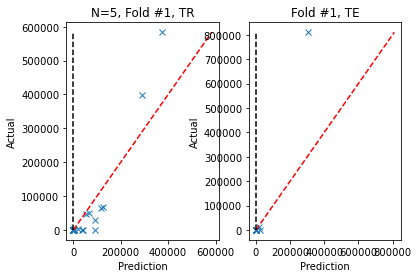

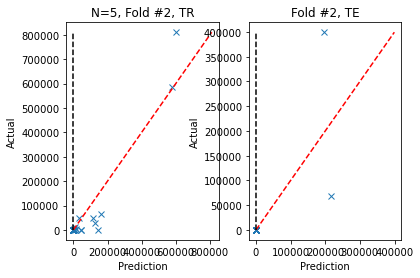

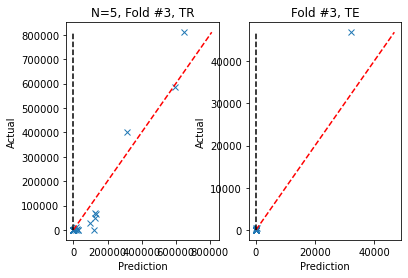

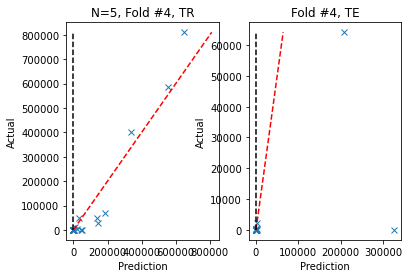

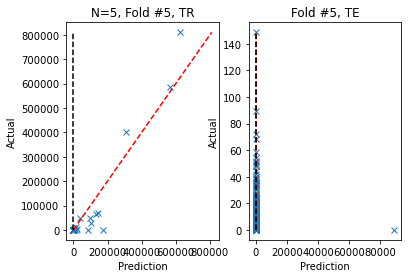

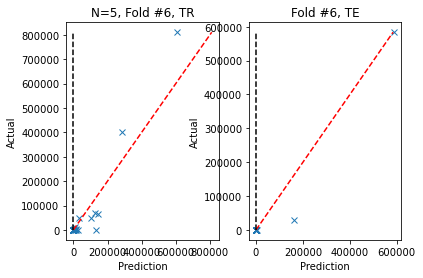

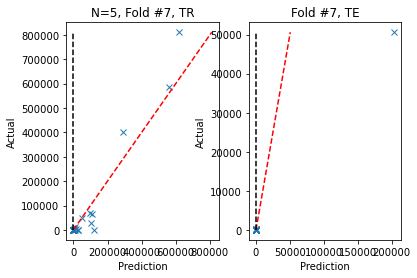

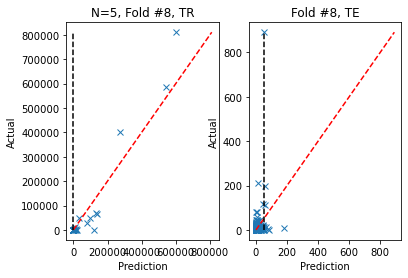

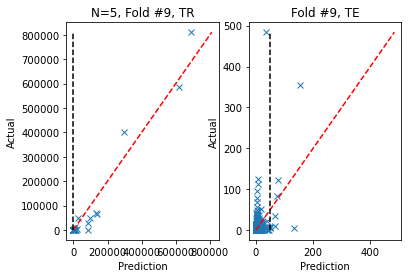

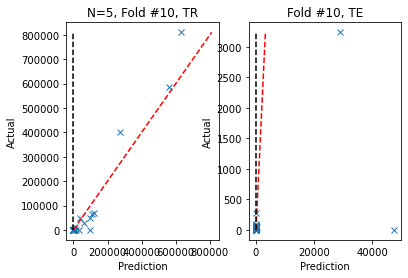

In [25]:
k = 10
N = 5
remove_n = 0
bw = 50
x_data, y_data, descriptive_x_data = load_data(N, remove_n, prepare_data=False)
tr_output, te_output = rfr_model_eval(x_data, y_data, descriptive_x_data, k, N, bw, full_verbose=True)

Fold=1, Over 100 Prediction Club:
	TEST:
		Company=HUB GROUP INC  -CL A, Ticker=HUBG, Date=2004, Prediction=129, Actual=6, r=20%
		Company=INSMED INC, Ticker=INSM, Date=2009, Prediction=663, Actual=20, r=35%
		Company=COMMERCIAL VEHICLE GROUP INC, Ticker=CVGI, Date=2009, Prediction=133, Actual=18, r=33%
		Company=DAVE & BUSTER'S ENTMT INC, Ticker=PLAY, Date=1995, Prediction=154009, Actual=66238, r=203%
	TRAIN:
		Company=CHARTER COMMUNICATIONS INC, Ticker=CHTR, Date=2009, Prediction=27237, Actual=10934, r=153%
		Company=PALOMAR MED TECHNOLOGIES INC, Ticker=PMTI, Date=1999, Prediction=253, Actual=2, r=9%
		Company=REX AMERICAN RESOURCES CORP, Ticker=REX, Date=2008, Prediction=227, Actual=303, r=77%
		Company=MEDICINES CO (THE), Ticker=MDCO, Date=2007, Prediction=199, Actual=3, r=10%
		Company=ARROWHEAD PHARMACEUTICALS, Ticker=ARWR, Date=2009, Prediction=130, Actual=189, r=69%
		Company=SOUTHERN COPPER CORP, Ticker=SCCO, Date=1999, Prediction=197, Actual=302, r=77%
		Company=IMMUNEX CORP,

Fold=3, Over 100 Prediction Club:
	TEST:
		Company=WHITING PETROLEUM CORP, Ticker=WLL, Date=2002, Prediction=86233, Actual=103274, r=217%
		Company=CYCLACEL PHARMACEUTICALS, Ticker=CYCC, Date=2009, Prediction=107, Actual=2, r=6%
	TRAIN:
		Company=INSMED INC, Ticker=INSM, Date=2009, Prediction=287, Actual=20, r=35%
		Company=LEAR CORP, Ticker=LEA, Date=2009, Prediction=166, Actual=206, r=70%
		Company=NUSTAR ENERGY LP, Ticker=NS, Date=2002, Prediction=204, Actual=252, r=74%
		Company=DAVE & BUSTER'S ENTMT INC, Ticker=PLAY, Date=1995, Prediction=86302, Actual=66238, r=203%
		Company=CELGENE CORP, Ticker=CELG, Date=1998, Prediction=107, Actual=166, r=67%
		Company=CHARTER COMMUNICATIONS INC, Ticker=CHTR, Date=2009, Prediction=6575, Actual=10934, r=153%
		Company=PALOMAR MED TECHNOLOGIES INC, Ticker=PMTI, Date=1999, Prediction=210, Actual=2, r=9%
		Company=REX AMERICAN RESOURCES CORP, Ticker=REX, Date=2008, Prediction=240, Actual=303, r=77%
		Company=MEDICINES CO (THE), Ticker=MDCO, Date=2

Fold=5, Over 100 Prediction Club:
	TEST:
		Company=LEE ENTERPRISES INC, Ticker=LEE, Date=2008, Prediction=108, Actual=3, r=11%
		Company=YORK WATER CO, Ticker=YORW, Date=2004, Prediction=177, Actual=2, r=8%
		Company=SALLY BEAUTY HOLDINGS INC, Ticker=SBH, Date=2006, Prediction=869694, Actual=408889, r=264%
		Company=GENERAC HOLDINGS INC, Ticker=GNRC, Date=2010, Prediction=748827, Actual=95958, r=215%
		Company=SONIC AUTOMOTIVE INC  -CL A, Ticker=SAH, Date=2009, Prediction=124, Actual=11, r=27%
	TRAIN:
		Company=INSMED INC, Ticker=INSM, Date=2009, Prediction=318, Actual=20, r=35%
		Company=LEAR CORP, Ticker=LEA, Date=2009, Prediction=169, Actual=206, r=70%
		Company=SPECTRUM PHARMACEUTICALS INC, Ticker=SPPI, Date=2003, Prediction=111, Actual=127, r=62%
		Company=NUSTAR ENERGY LP, Ticker=NS, Date=2002, Prediction=182, Actual=252, r=74%
		Company=DAVE & BUSTER'S ENTMT INC, Ticker=PLAY, Date=1995, Prediction=118423, Actual=66238, r=203%
		Company=CELGENE CORP, Ticker=CELG, Date=1998, Predi

Fold=7, Over 100 Prediction Club:
	TEST:
		Company=SPARTANNASH CO, Ticker=SPTN, Date=1994, Prediction=4820, Actual=98, r=58%
		Company=GLAXOSMITHKLINE PLC, Ticker=GSK, Date=2008, Prediction=263, Actual=1, r=-3%
		Company=STAMPS.COM INC, Ticker=STMP, Date=2001, Prediction=101, Actual=1, r=3%
		Company=ACTIVISION BLIZZARD INC, Ticker=ATVI, Date=2007, Prediction=1006935, Actual=2012191, r=327%
	TRAIN:
		Company=INSMED INC, Ticker=INSM, Date=2009, Prediction=253, Actual=20, r=35%
		Company=LEAR CORP, Ticker=LEA, Date=2009, Prediction=166, Actual=206, r=70%
		Company=NUSTAR ENERGY LP, Ticker=NS, Date=2002, Prediction=176, Actual=252, r=74%
		Company=DAVE & BUSTER'S ENTMT INC, Ticker=PLAY, Date=1995, Prediction=67054, Actual=66238, r=203%
		Company=CELGENE CORP, Ticker=CELG, Date=1998, Prediction=123, Actual=166, r=67%
		Company=CHARTER COMMUNICATIONS INC, Ticker=CHTR, Date=2009, Prediction=8589, Actual=10934, r=153%
		Company=PALOMAR MED TECHNOLOGIES INC, Ticker=PMTI, Date=1999, Prediction=

Fold=9, Over 100 Prediction Club:
	TEST:
		Company=LINCOLN ELECTRIC HLDGS INC, Ticker=LECO, Date=1993, Prediction=16171, Actual=1149, r=102%
		Company=ACTIVISION BLIZZARD INC, Ticker=ATVI, Date=2008, Prediction=1248150, Actual=2035126, r=327%
		Company=EXACT SCIENCES CORP, Ticker=EXAS, Date=2009, Prediction=955921, Actual=481, r=85%
		Company=VISTEON CORP, Ticker=VC, Date=2009, Prediction=11647, Actual=126, r=62%
	TRAIN:
		Company=INSMED INC, Ticker=INSM, Date=2009, Prediction=239, Actual=20, r=35%
		Company=LEAR CORP, Ticker=LEA, Date=2009, Prediction=287, Actual=206, r=70%
		Company=SPECTRUM PHARMACEUTICALS INC, Ticker=SPPI, Date=2003, Prediction=110, Actual=127, r=62%
		Company=NUSTAR ENERGY LP, Ticker=NS, Date=2002, Prediction=177, Actual=252, r=74%
		Company=DAVE & BUSTER'S ENTMT INC, Ticker=PLAY, Date=1995, Prediction=64600, Actual=66238, r=203%
		Company=CELGENE CORP, Ticker=CELG, Date=1998, Prediction=110, Actual=166, r=67%
		Company=CHARTER COMMUNICATIONS INC, Ticker=CHTR, Dat

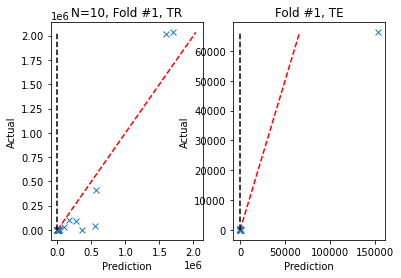

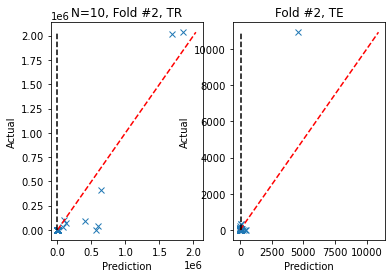

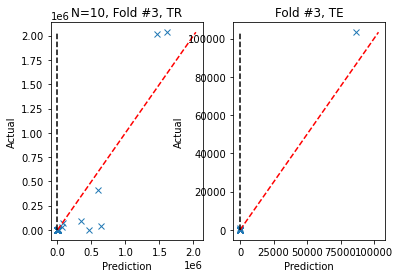

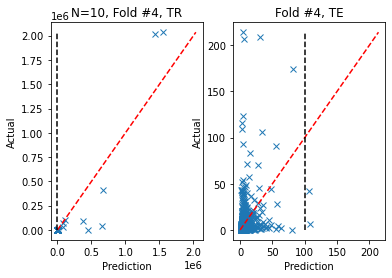

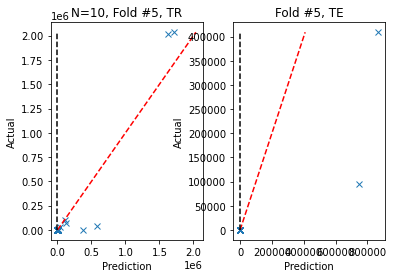

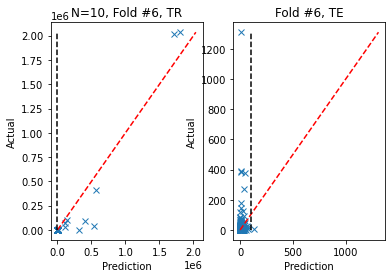

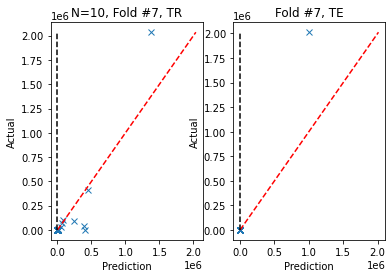

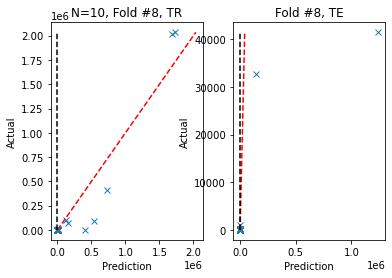

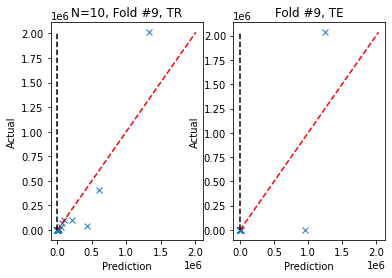

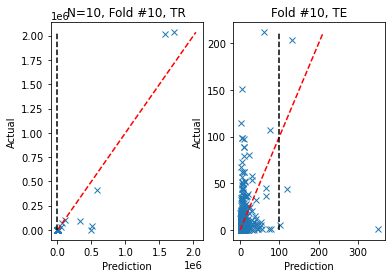

In [26]:
k = 10
N = 10
remove_n = 0
bw = 100
x_data, y_data, descriptive_x_data = load_data(N, remove_n, prepare_data=False)
tr_output, te_output = rfr_model_eval(x_data, y_data, descriptive_x_data, k, N, bw, full_verbose=True)

# Train and save models

In [ ]:
N = [5, 10]
for n in N:
    filename = 'model_N'+str(n)+'.sav'
    x_data, y_data, descriptive_x_data = load_data(n, remove_n=0, prepare_data=False)
    model = RandomForestRegressor(bootstrap=True, oob_score=True, verbose=0)
    model.fit(x_data, y_data.ravel())
    joblib.dump(model, filename, compress=3)

## Save training x-data for future processing

In [ ]:
N_list = [5, 10]
for N in N_list:
    # Re-load data
    x_data = pd.read_csv('X_data_N'+str(N)+'.csv')
    data = deepcopy(x_data)
    data = data.drop('MarketCapDate', axis=1)
    data.insert(4, 'MarketCapDate', x_data['MarketCapDate'])
    # Reduce x_data to just training features
    input_features = x_data.columns
    training_features = list(input_features[4:])
    training_features.remove('MarketCapDate')
    # Compute financial ratios to use as training features
    x_ratio_data = compute_ratio_data(x_data[training_features])
    x_ratio_data, data, clean_idx = clean_dataset(x_ratio_data, data)
    x_data = x_data.reset_index(drop=True)
    data.reset_index(drop=True)
    # Save data
    x_ratio_data2 = pd.concat([data.iloc[:,0:5],x_ratio_data],axis=1)
    x_ratio_data2.to_csv('X_ratio_data_N'+str(N)+'.csv', index=False)

# Develop Training Data Process Control Statistics

## Compute & save statistics

In [ ]:
# Load data
N = 5
x_data = pd.read_csv('X_ratio_data_N'+str(N)+'.csv')
training_features = x_data.columns[5:]

# Extract year list of training dataset
x_data['StatementDate'] = pd.to_datetime(x_data['StatementDate'])
year_list = x_data['StatementDate'].dt.year.unique()
year_list.sort()

# Compute statistics
drift_stats = np.zeros((len(training_features),len(year_list),2))
data_tr = x_data[training_features]
for j, year in enumerate(year_list):
    # Extract only data from current year
    year_data = data_tr.loc[x_data['StatementDate'].dt.year == year]
    # Min-max normalize the current year's data
    year_data = min_max_transform(year_data, year_data.columns)
    # Compute mean & stddev for each feature of current year's data
    for i, feat in enumerate(training_features):
        drift_stats[i,j,0] = year_data[feat].mean()
        drift_stats[i,j,1] = year_data[feat].std()
        
# Format data for output
mu = drift_stats[:,:,0].T
sd = drift_stats[:,:,1].T
years = np.array(year_list).reshape(-1,1)
mu_df = pd.DataFrame(mu, columns = training_features)
sd_df = pd.DataFrame(sd, columns = training_features)
yr_df = pd.DataFrame(years, columns = ['Year'])

# Save data for future 
mu_df = pd.concat([yr_df, mu_df], axis=1).to_csv('mu_stats.csv', index=False)
sd_df = pd.concat([yr_df, sd_df], axis=1).to_csv('sd_stats.csv', index=False)

## Output Hotelling T^2 control chart 

In [ ]:
# 95% confidence interval
alpha = 0.95 
# Compute t^2 distributions for mean & standard deviations
mu_t2, ucl = hotelling_t2(mu, alpha)
sd_t2, ucl = hotelling_t2(sd, alpha)
# Define plot paramters
linestyle = ['-ok','--r']
leg = ['t^2, unweighted','UCL']
# Output mean SPC chart
t = np.hstack((years, years))
y = np.hstack((mu_t2, np.ones((len(mu_t2),1))*ucl))
time_series_plot(t, y, 'MU', 'Year', '', linestyle, leg)
# Output std SPC chart
y = np.hstack((sd_t2, np.ones((len(sd_t2),1))*ucl))
time_series_plot(t, y, 'SD', 'Year', '', linestyle, leg)
# Output combined SPC chart
comb_t2, ucl = hotelling_t2(mu+sd, alpha)
y = np.hstack((comb_t2, np.ones((len(comb_t2),1))*ucl))
time_series_plot(t, y, 'MU+SD', 'Year', '', linestyle, leg)